In [ ]:
import cartopy.crs as ccrs
import fsspec
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import planetary_computer
import pystac_client
import xarray as xr
import requests
import geopandas as gpd

In [ ]:
planetary_computer.set_subscription_key("c27669c4bdec434d804e2bd738cb16fc")
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [ ]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)
items = search.item_collection()

print(items)

In [ ]:
f = fsspec.open().open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
f

---
### 05/09/2023
---

### Debugging the program

---

|HCHO Product
---

In [ ]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "hcho"}},
)
hcho_items = search.item_collection()

|CH4 Product
---

In [ ]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)
ch4_items = search.item_collection()

**Debug Test 1**: Check if the item collection returned corresponds to target product 

|HCHO Product
---

In [ ]:
hcho_items

|CH4 Product
---

In [ ]:
ch4_items

**Observations**:

Both queried results showed both from the s5p level 2 collections with their respective product name and type.

**Conclusion**:

There is no issue with querying for the product

---

**Debug Test 2**: Check if the href of one of the item product is downloadable

|HCHO Product
---

In [ ]:
# Get the href of the first product 
# The href is inside the asset attribute
hcho_items[0].assets["hcho"].href

|CH4 Product
---

In [ ]:
# Get the href of the first product 
# The href is inside the asset attribute
ch4_items

**Debug Test 3**: Check if the downloaded product can be opened using netcdf4 and set into an xarray dataset

These will be done on 3 levels:
1. File header
2. "Product" group attribute
3. Actual longitude, latitude and concentration data

In [ ]:
import netCDF4 as nc

##### 1. File Header

|HCHO Product
---

In [ ]:
file = "Download Results\S5P_OFFL_L2__HCHO___20230403T063304_20230403T081434_28345_03_020401_20230404T225423.nc"
hcho_fh = nc.Dataset(file, mode='r')
hcho_fh

|CH4 Product
---

In [ ]:
file = "Download Results\S5P_OFFL_L2__CH4____20230403T063304_20230403T081434_28345_03_020500_20230404T225423.nc"
ch4_fh = nc.Dataset(file, mode='r')
ch4_fh

##### 2. "PRODUCT" group attribute

In [ ]:
hcho_fh.groups["PRODUCT"]

**Observations**:

Both codes returned a href link that links to the downloadable nc file in the Azure Blob Storage. These documents were downloaded by simply clicking on the link. 

Both have resulted in proper nc files that are the same as the ones that are downloaded through Copernicus Open Hub.

**Conclusion**:

There is no issue with downloading the product

---

In [ ]:
ch4_fh.groups["PRODUCT"]

##### 3. Longitude, latitude and concentration values

In [ ]:
lon = hcho_fh.groups["PRODUCT"].variables['longitude']
lat = hcho_fh.groups["PRODUCT"].variables['latitude']
hcho = hcho_fh.groups["PRODUCT"].variables['formaldehyde_tropospheric_vertical_column']

print(lon) 
print('\n\n')
print(lat)
print('\n\n')
print(hcho)

In [ ]:
lon = ch4_fh.groups["PRODUCT"].variables['longitude']
lat = ch4_fh.groups["PRODUCT"].variables['latitude']
ch4 = ch4_fh.groups["PRODUCT"].variables['methane_mixing_ratio']
ch4_bias_corrected = ch4_fh.groups["PRODUCT"].variables['methane_mixing_ratio_bias_corrected']

print(lon) 
print('\n\n')
print(lat)
print('\n\n')
print(ch4)
print('\n\n')
print(ch4_bias_corrected)

**Observations**:

Data is clearly intact for both products. All three levels are accessible with no issues in values.

**Conclusion**:

There is no issue with navigating through the product using nc4.Therefore, the issue is not to do with authentication but more likely to do with the xarray code instead.

---

**Debug Test 4**: Check if the queried product can be opened and set into an xarray dataset

|HCHO Product
---

In [ ]:
f = fsspec.open(hcho_items[0].assets['hcho'].href).open()
ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
ds

|CH4 Product
---

In [ ]:
f = fsspec.open(ch4_items[0].assets['ch4'].href)
print(type(f))
print(type(f.open()))
# ds = xr.open_dataset(f, group="PRODUCT", engine="h5netcdf")
# ds

**Observations**:

No issues with HCHO Product but CH4 ends with an error after 40 mins of running.

**Conclusion**:

Will need to check if the data can be run in Microsoft Planetary Computer Hub. If it works, then the issue may lie within the authentication aspect. If not, it will be within the xarray library.

---

**Debug Test 5**: Running the code in Microsoft Planetary Computer Hub

The code will be run in the Hub to determine if the CH4 dataset is facing the same issue. If it runs well, then the issue of the matter may lie in the data authentication aspect.

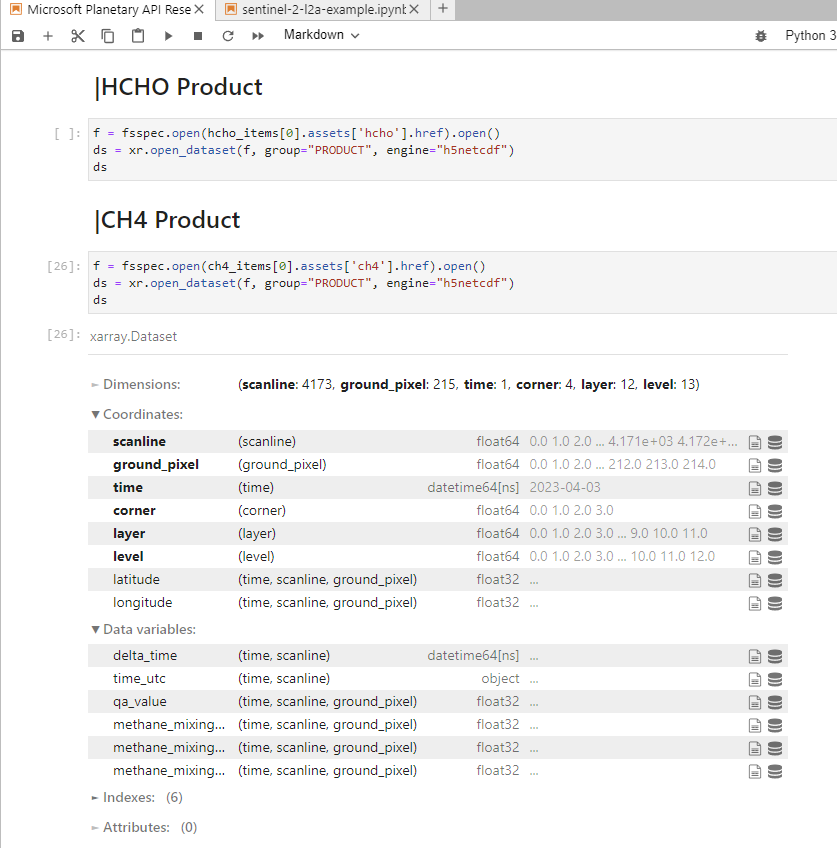

It was possible to set the data into an xarray dataset. Therefore, the authentication may be the issue. Will need to explore further into how the authentication works.

# MS Planet Data Authentication

---

Researching data authentication for STAC API as datsets for CH4 is not accessible for unknown reason. It took more than 40 mins and ends in an error.

This could be a result of not providing data tokens to access despite the fact that MS Planet's HCHO example worked fine without it.

Resource:
- https://planetarycomputer.microsoft.com/docs/concepts/sas/

---

## **Token**

A SAS token is needed whenver acess to the Planetary Computer at an Azure Blob URL is required.

### **Request a Token**
#### Token Endpoints
- https://planetarycomputer.microsoft.com/api/sas/v1/token/{collection_id} 
- https://planetarycomputer.microsoft.com/api/sas/v1/token/{storage_account}/{container}

These endpoints allow for SAS token generation for a given dataset identified by it's collection ID.  If the Azure Blob storage account is known, the second endpoint above can be used.

To request a token in a code, we can use python requests.

***NOTE:*** Additionally, we can supply the subscription API key if a MS Planet account has been created and approved by appending it to end of the token query.


In [ ]:
import requests

# Get token for Sentinel-5P Level 2A collection
# collection_id for CH4 is 'sentinel-5p-l2-netcdf'
token_endpoint = "https://planetarycomputer.microsoft.com/api/sas/v1/token/sentinel-5p-l2-netcdf"
token_endpoint_w_apikey = "https://planetarycomputer.microsoft.com/api/sas/v1/token/sentinel-5p-l2-netcdf?subscription-key=c27669c4bdec434d804e2bd738cb16fc"
response = requests.get(token_endpoint_w_apikey)
response.json()

From the output above:
- **'msft:expriry'**: The expiry date of the token
- **'token'**: The token for an given identified collection


To utilize the token, it must be appended with URL endpoint with a '?'. 

|URL + "?" + token = URL?token
---

---
### **Signed URL Test**

In [ ]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace
)

In [ ]:
longitude = 79.109
latitude = 22.746

geometry = {
    "type": "Point",
    "coordinates": [longitude, latitude],
}

search = catalog.search(
    collections="sentinel-5p-l2-netcdf",
    intersects=geometry,
    datetime="2023-04-02/2023-04-03",
    query={"s5p:processing_mode": {"eq": "OFFL"}, "s5p:product_name": {"eq": "ch4"}},
)

items = search.item_collection()
print(f"Found {len(items)} items:")

items[1].assets["ch4"]
f = fsspec.open(items[1].assets["ch4"].href).open()
ds = xr.open_dataset(f, group="PRODUCT")
ds